# Demonstration of `DroneWQ` functions and processing code

Pull in all the modules needed for this code.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from cartopy.crs import Mercator

plt.rcParams['mathtext.default'] = 'regular'

from utils import *

To process raw MicaSense imagery to corrected remote sensing reflectance (Rrs) imagery, you can use the `process_raw_to_rrs()` function. 

Make sure your imagery has been manually organized into this exact structure (name the main_dir whatever you want but keep the rest exactly as named here):
```
    <main_dir>/
        raw_water_imgs/
        align_img/
        raw_sky_imgs/
        panel/
```

With that structure now just specify the path to <main_dir> below:

In [2]:
project_path = os.path.join('Broadford_Lake_for_DroneWQ/group_2')
project_path


'Broadford_Lake_for_DroneWQ/group_2'

We can use the `write_metadata_csv()` function to save all the image metadata to a .csv. Let's open it to take a look.

In [3]:
write_metadata_csv(img_set = imageset.ImageSet.from_directory(project_path+'/raw_water_imgs'),
                                                            csv_output_path=project_path)
img_metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
img_metadata

Loading ImageSet from: Broadford_Lake_for_DroneWQ/group_2/raw_water_imgs


,filename,dirname,DateStamp,TimeStamp,Latitude,LatitudeRef,Longitude,LongitudeRef,Altitude,SensorX,...,FocalLength,Yaw,Pitch,Roll,SolarElevation,ImageWidth,ImageHeight,XResolution,YResolution,ResolutionUnits
0,capture_1.tif,Broadford_Lake_for_DroneWQ/group_2/capture_1.tif,2022-09-09,14:17:23,39.410037,N,-79.370726,W,831.330,4.8,...,5.43432,118.514265,8.463416,6.055303,0.653133,1280,960,266.666667,266.666667,mm
1,capture_2.tif,Broadford_Lake_for_DroneWQ/group_2/capture_2.tif,2022-09-09,14:17:24,39.410028,N,-79.370895,W,831.411,4.8,...,5.43432,118.125064,5.659621,4.811205,0.653181,1280,960,266.666667,266.666667,mm
2,capture_3.tif,Broadford_Lake_for_DroneWQ/group_2/capture_3.tif,2022-09-09,14:17:25,39.410019,N,-79.371110,W,831.420,4.8,...,5.43432,118.162412,15.625344,2.788795,0.653276,1280,960,266.666667,266.666667,mm
3,capture_4.tif,Broadford_Lake_for_DroneWQ/group_2/capture_4.tif,2022-09-09,14:17:27,39.410014,N,-79.371275,W,831.439,4.8,...,5.43432,117.883687,11.595312,5.882098,0.653373,1280,960,266.666667,266.666667,mm
4,capture_5.tif,Broadford_Lake_for_DroneWQ/group_2/capture_5.tif,2022-09-09,14:17:28,39.410007,N,-79.371472,W,831.399,4.8,...,5.43432,117.651211,10.551933,4.184692,0.653419,1280,960,266.666667,266.666667,mm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,capture_194.tif,Broadford_Lake_for_DroneWQ/group_2/capture_194...,2022-09-09,14:23:11,39.412003,N,-79.373052,W,831.218,4.8,...,5.43432,99.254458,21.212127,3.377123,0.670088,1280,960,266.666667,266.666667,mm
194,capture_195.tif,Broadford_Lake_for_DroneWQ/group_2/capture_195...,2022-09-09,14:23:12,39.411996,N,-79.373192,W,831.288,4.8,...,5.43432,98.283471,20.572292,2.333593,0.670184,1280,960,266.666667,266.666667,mm
195,capture_196.tif,Broadford_Lake_for_DroneWQ/group_2/capture_196...,2022-09-09,14:23:13,39.411988,N,-79.373388,W,831.447,4.8,...,5.43432,97.890639,18.986936,3.969578,0.670230,1280,960,266.666667,266.666667,mm
196,capture_197.tif,Broadford_Lake_for_DroneWQ/group_2/capture_197...,2022-09-09,14:23:15,39.411975,N,-79.373610,W,831.649,4.8,...,5.43432,101.296133,332.837131,350.340041,0.670324,1280,960,266.666667,266.666667,mm


We can use the metadata to plot the altitude, lat,lon location, and the yaw of image captures

Text(0, 0.5, 'Yaw')

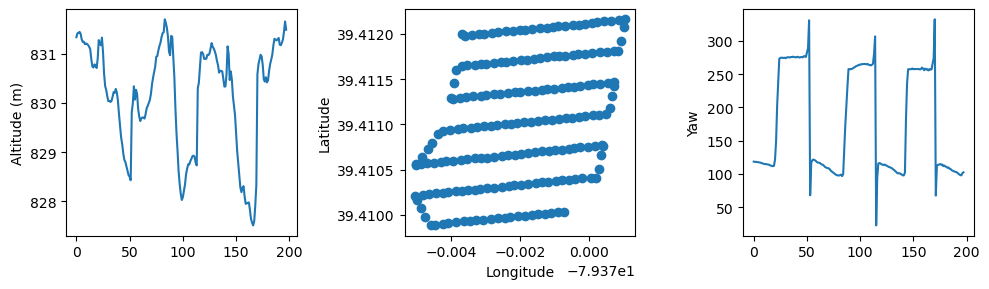

In [4]:
fig, ax = plt.subplots(1,3, figsize=(10,3), layout='tight')

ax[0].plot(list(range(len(img_metadata))),img_metadata['Altitude'])
ax[0].set_ylabel('Altitude (m)')

ax[1].scatter(img_metadata['Longitude'], img_metadata['Latitude'])
ax[1].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')

ax[2].plot(list(range(len(img_metadata))),img_metadata['Yaw'])
ax[2].set_ylabel('Yaw')

Now let's get to processing. 
The `process_raw_to_rrs()` function has a number of options that you can see here:

In [5]:
?process_raw_to_rrs

Signature:
process_raw_to_rrs(
    main_dir,
    rrs_dir_name,
    output_csv_path,
    lw_method='mobley_rho_method',
    mask_pixels=False,
    random_n=10,
    pixel_masking_method='value_threshold',
    mask_std_factor=1,
    nir_threshold=0.01,
    green_threshold=0.005,
    ed_method='dls_ed',
    overwrite_lt_lw=False,
    clean_intermediates=True,
)
Docstring:
This functions is the main processing script that processs raw imagery to units of remote sensing reflectance (Rrs). Users can select which processing parameters to use to calculate Rrs.

Inputs: 
main_dir: A string containing the main image directory
rrs_dir_name: A string containing the directory filepath of new rrs images
output_csv_path: A string containing the filepath to write the metadata.csv 
lw_method: Method used to calculate water leaving radiance. Default is mobley_rho_method().
random_n: The amount of random images to calculate ambient NIR level. Default is 10. Only need if lw_method = 'hedley_method'
mask_pi

Below we show an example of this function in action with one of our provided sample datasets. For this example, we're calculating water leaving radiance (Lw) using the Hedley approach, calculating downwelling irradiance (Ed) using the downwelling light sensor (DLS). We are applying the default masking procedure. We'll save processed images out two directories called `rrs_hedley` and `masked_rrs_hedley`.

In summary, this code will process: Raw -> Lt -> Lw (Hedley method) -> Rrs (using Ed from DLS) with pixel masking

In [11]:
process_raw_to_rrs(main_dir=project_path, rrs_dir_name='rrs_hedley', output_csv_path=project_path, lw_method='hedley_method', 
                   random_n=10, mask_pixels=True, pixel_masking_method='value_threshold', ed_method='dls_ed', 
                   overwrite_lt_lw=False, clean_intermediates=False)


Loading ImageSet from: Broadford_Lake_for_DroneWQ/group_2/align_img
Processing a total of 990 images or 198 captures.
Converting raw images to radiance (raw -> Lt).
Loading ImageSet from: Broadford_Lake_for_DroneWQ/group_2/raw_water_imgs
Loading ImageSet from: Broadford_Lake_for_DroneWQ/group_2/align_img
used warp dir Broadford_Lake_for_DroneWQ/group_2/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 2
Finished aligning band 4
Saving time: 0:04:36.247601
Alignment+Saving rate: 0.72 images per second
Finished saving images.
Finished saving image metadata.
Applying the Hochberg/Hedley (Lt -> Lw)
Normalizing by DLS irradiance (Lw/Ed -> Rrs).
Loading ImageSet from: Broadford_Lake_for_DroneWQ/group_2/raw_water_imgs
All data has been saved as Rrs using the hedley_method to calculate Lw and normalized by dls_ed irradiance.
Masking pixels using NIR 

True

To grab these processed images and their metadata you can use the helper function `retrieve_imgs_and_metadata()`. The images can also easily be loaded in with the lower level `load_images()` function or even just with rasterio's `open()` function but the higher level `retrieve_imgs_and_metadata()` allows you to apply an altitude cutoff and limit the number of files being opened. 

Note that this will open as many files as you ask and if you have 1000+ images this is likely more than you can load into memory. In the case of large processing jobs it will likely be more appropriate to loop through the files individually or in batches which can be done by looping the `start` and `count` arguments in `retrieve_imgs_and_metadata()`.

In [8]:
?retrieve_imgs_and_metadata

Signature:
retrieve_imgs_and_metadata(
    img_dir,
    count=10000,
    start=0,
    altitude_cutoff=0,
    sky=False,
    random=False,
)
Docstring:
This function is the main interface we expect the user to use when grabbing a subset of imagery from any stage in processing. This returns the images as a numpy array and metadata as a pandas dataframe. 

Inputs:
img_dir: A string containing the directory filepath of images to be retrieved
count: The amount of images you want to list. Default is 10000
start: The number of image to start on. Default is 0 (first image in img_dir). 
random: A boolean to load random images. Default is False

Outputs: A multidimensional numpy array of all image captures in a directory and a Pandas dataframe of image metadata. 
File:      /glusteruser/awindled/DroneWQ/utils.py
Type:      function

Let's retrieve the Rrs data and visualize the first 5 images

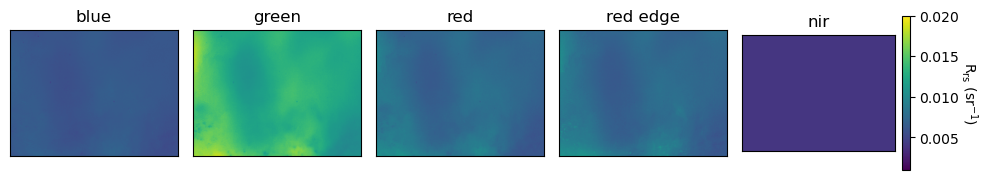

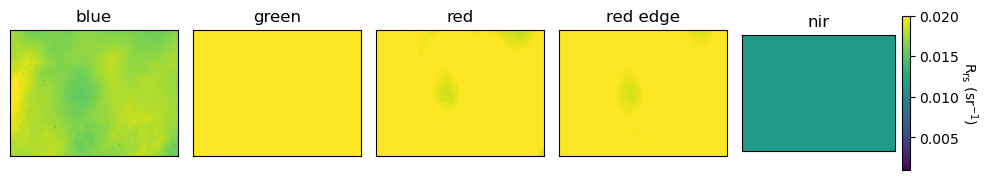

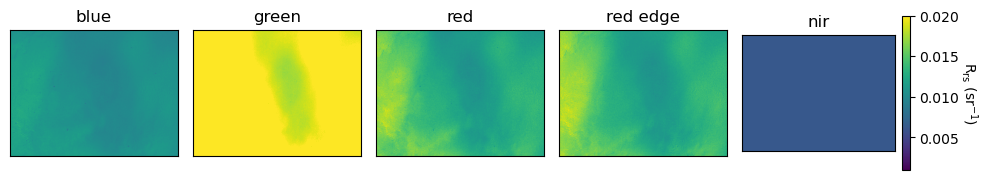

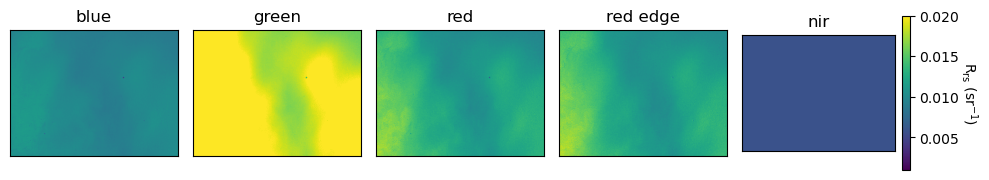

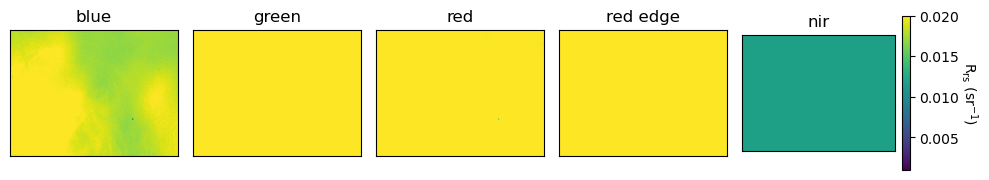

In [12]:
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'rrs_hedley'))

band_names = ['blue', 'green', 'red', 'red edge', 'nir']

for j in range(len(rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(rrs_imgs_hedley[j,i], cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

We can also visualize the masked Rrs

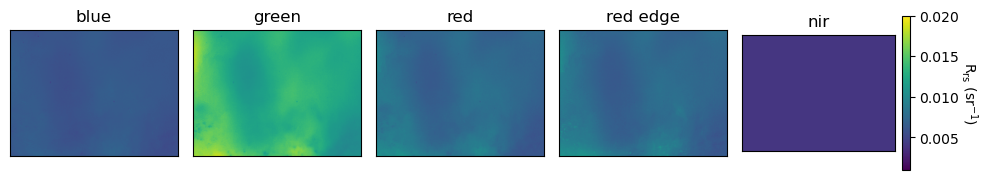

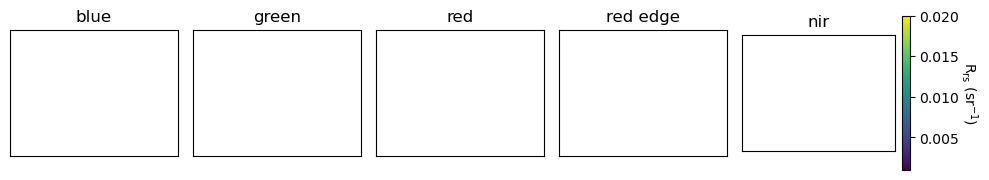

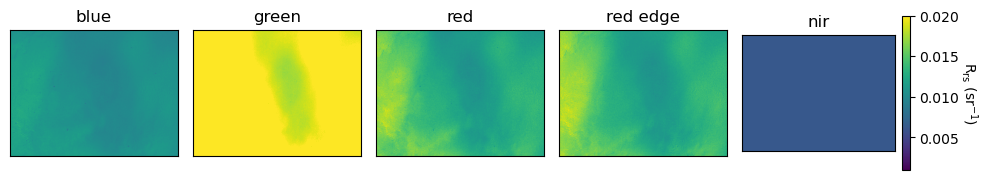

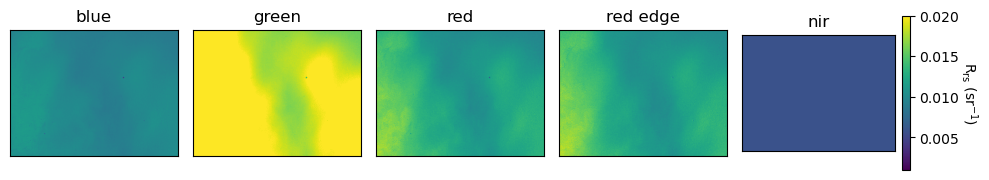

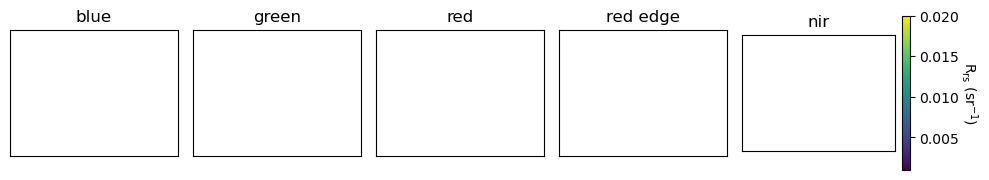

In [13]:
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'masked_rrs_hedley'))

for j in range(len(masked_rrs_imgs_hedley[0:5])):
    fig, ax = plt.subplots(1,5, figsize=(10,3.5))
    for i in range(5):
        im = ax[i].imshow(masked_rrs_imgs_hedley[j,i],cmap='viridis', vmin=0.001, vmax=0.02)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(band_names[i])
    cbar = fig.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
    cbar.set_label('$R_{rs}\ (sr^{-1}$)', rotation=270, labelpad=15)
    fig.tight_layout() 
    plt.show()

Let's plot the Rrs spectra of all images to see if it looks reasonable

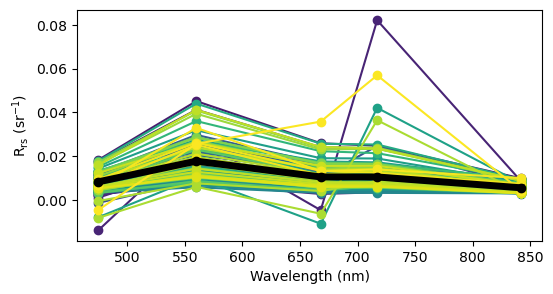

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)), marker = 'o', color=colors[i], label="")
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$R_{rs}\ (sr^{-1}$)') 
plt.plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')


Actually, we can plot Lt, Lw, Ed spectra as well. First, we need to retrieve all the data.

In [16]:
lt_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lt_imgs')
#lsky_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/sky_lt_imgs', sky=True)
lw_imgs, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/lw_imgs')
dls_ed = pd.read_csv(project_path+'/dls_ed.csv') 
rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/rrs_hedley')
masked_rrs_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')

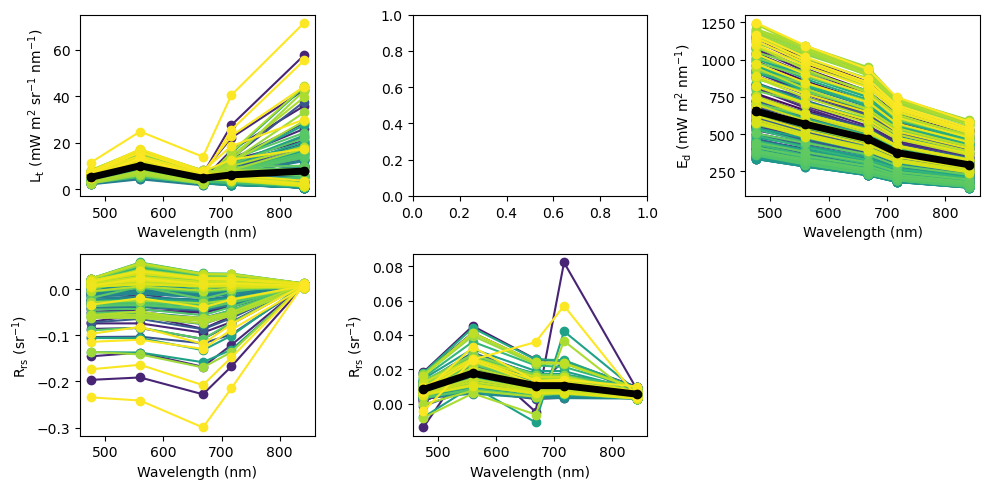

In [17]:
fig, axs = plt.subplots(2,3, figsize=(10,5))

axs = axs.ravel()

wv = [475, 560, 668, 717, 842]
colors = plt.cm.viridis(np.linspace(0,1,len(lt_imgs)))

#lt
for i in range(len(lt_imgs)):
    axs[0].plot(wv, np.nanmean(lt_imgs[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('$L_t\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')   
axs[0].plot(wv, np.nanmean(lt_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')
'''
#lsky
colors = plt.cm.viridis(np.linspace(0,1,len(lsky_imgs)))

for i in range(len(lsky_imgs)):
    axs[1].plot(wv, lsky_imgs[i,0:5,:,:].mean(axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('$L_{sky}\ (mW\ m^2\ sr^{-1}\ nm^{-1}$)')    
axs[1].plot(wv, np.nanmean(lsky_imgs[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')
'''
#dls ed
ed = pd.read_csv(project_path+'/dls_ed.csv')
colors = plt.cm.viridis(np.linspace(0,1,len(ed)))

for i in range(len(ed)):
    axs[2].plot(wv, ed.iloc[i,1:6],  marker = 'o', color=colors[i]) 
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('$E_d\ (mW\ m^2\ nm^{-1}$)') 
axs[2].plot(wv, ed.iloc[:,1:6].mean(axis=0),  marker = 'o', color='black', linewidth=5, label='Average')

#rrs_imgs_hedley
colors = plt.cm.viridis(np.linspace(0,1,len(rrs_imgs_hedley)))

for i in range(len(rrs_imgs_hedley)):
    axs[3].plot(wv, np.nanmean(rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[3].set_xlabel('Wavelength (nm)')
    axs[3].set_ylabel('$R_{rs}\ (sr^{-1}$)') 

#rrs_imgs_hedley_masked
colors = plt.cm.viridis(np.linspace(0,1,len(masked_rrs_imgs_hedley)))

for i in range(len(masked_rrs_imgs_hedley)):
    axs[4].plot(wv, np.nanmean(masked_rrs_imgs_hedley[i,0:5,:,:],axis=(1,2)),  marker = 'o', color=colors[i], label="")
    axs[4].set_xlabel('Wavelength (nm)')
    axs[4].set_ylabel('$R_{rs}\ (sr^{-1}$)')   
axs[4].plot(wv, np.nanmean(masked_rrs_imgs_hedley[:,0:5,:,:], axis=(0,2,3)),  marker = 'o', color='black', linewidth=5, label='Average')

fig.delaxes(axs[5])
fig.tight_layout() 


You might be interested in averaging values for every image, to work with point samples. This code takes the mean of Rrs for every band and saves them to a Pandas dataframe with the dirname, lat, and lon

In [51]:
rrs_blue = []
rrs_green = []
rrs_red = []
rrs_rededge = []
rrs_nir= []

for i in range(len(rrs_imgs_hedley)):
    rrs_blue.append(np.nanmean(rrs_imgs_hedley[i,0,:,:]))
    rrs_green.append(np.nanmean(rrs_imgs_hedley[i,1,:,:]))
    rrs_red.append(np.nanmean(rrs_imgs_hedley[i,2,:,:]))
    rrs_rededge.append(np.nanmean(rrs_imgs_hedley[i,3,:,:]))
    rrs_nir.append(np.nanmean(rrs_imgs_hedley[i,4,:,:]))
    
df = img_metadata[['dirname', 'Latitude', 'Longitude']]
df['rrs_blue'] = rrs_blue
df['rrs_green'] = rrs_green
df['rrs_red'] = rrs_red
df['rrs_rededge'] = rrs_rededge
df['rrs_nir'] = rrs_nir    
df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir
filename,,,,,,,,
capture_1.tif,sample_datasets/lake_dataset/capture_1.tif,41.829367,-83.404884,0.008491,0.021283,0.010358,0.014654,0.004115
capture_2.tif,sample_datasets/lake_dataset/capture_2.tif,41.829504,-83.404885,0.008445,0.021133,0.010279,0.014565,0.004081
capture_3.tif,sample_datasets/lake_dataset/capture_3.tif,41.829640,-83.404886,0.008455,0.021146,0.010270,0.014546,0.004091
capture_4.tif,sample_datasets/lake_dataset/capture_4.tif,41.829780,-83.404886,0.008390,0.020790,0.010209,0.014016,0.004012
capture_5.tif,sample_datasets/lake_dataset/capture_5.tif,41.829801,-83.404903,0.008216,0.020920,0.010187,0.014741,0.004038


Easy to save as a .csv

In [52]:
df.to_csv(project_path + '/mean_rrs.csv')

Using the Rrs images, we can apply algorithms to derive chlorophyll a and total suspended matter (TSM) concentrations. See the paper.md for more information. Here, we are applying the blended NASA chlorophyll algorithm (Hu et al., 2019). 

In [53]:
chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=rrs_imgs_hedley[:,2,:,:])
print(chl_hu_ocx_imgs.shape)

(16, 928, 1227)


Let's take a quick look at a histogram of all chl values to make sure they are reasonable

11.779231


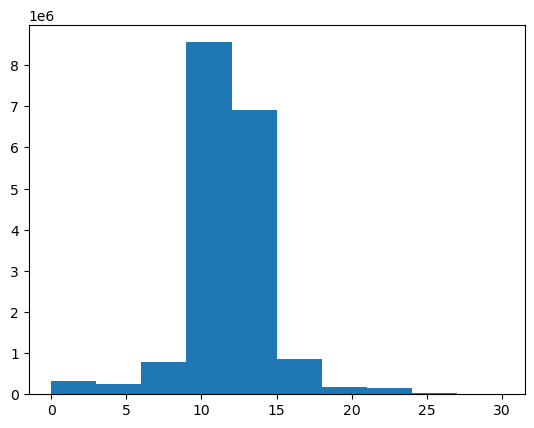

In [54]:
plt.hist(chl_hu_ocx_imgs.ravel(), range=[0, 30])
print(np.nanmedian(chl_hu_ocx_imgs))

The average value looks to be around 12 mg/m3, which is reasonable for estuarine waters. Now, we can save new .tifs processed with this algorithm. 

In [55]:
save_wq_imgs_batch(main_dir=project_path, rrs_img_dir='rrs_hedley', 
             wq_dir_name='chl_hu_ocx_imgs', wq_alg ='chl_hu_ocx') 

Processing images from capture_10.tif to capture_10.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Processing images from capture_11.tif to capture_11.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


Processing images from capture_13.tif to capture_13.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.73it/s]


Processing images from capture_12.tif to capture_12.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


Processing images from capture_16.tif to capture_16.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


Processing images from capture_15.tif to capture_15.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


Processing images from capture_14.tif to capture_14.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Processing images from capture_8.tif to capture_8.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.58it/s]


Processing images from capture_9.tif to capture_9.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


Processing images from capture_4.tif to capture_4.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.62it/s]


Processing images from capture_5.tif to capture_5.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


Processing images from capture_7.tif to capture_7.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Processing images from capture_6.tif to capture_6.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Processing images from capture_2.tif to capture_2.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Processing images from capture_3.tif to capture_3.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


Processing images from capture_1.tif to capture_1.tif


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


Let's visualize a few chl a images

TODO: Figure out why these are masked?? 

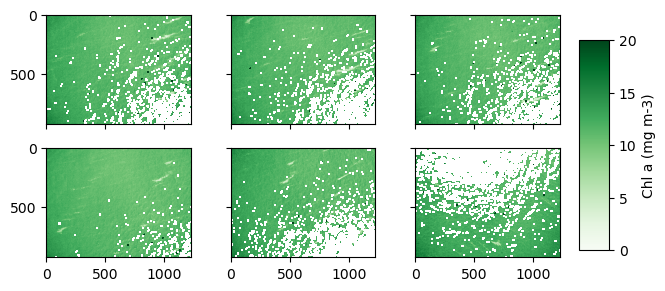

In [56]:
chl_imgs_hedley, img_metadata = retrieve_imgs_and_metadata(img_dir = os.path.join(project_path, 'chl_hu_ocx_imgs'))

fig, axs = plt.subplots(2,3, figsize=(6,3), sharex=True, sharey=True, layout='tight')

axs = axs.ravel()

for i in range(6):
    im = axs[i].imshow(chl_imgs_hedley[i,0,:,:], cmap='Greens', vmin=0, vmax=20)

cbar_ax = fig.add_axes([0.99, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Chl a (mg m-3)')

plt.show()

We can also save average chl-a/TSM concentrations for each image in dataframe to use as point data

In [57]:
chl_hu_ocx_imgs = chl_hu_ocx(Rrsblue=rrs_imgs_hedley[:,0,:,:], 
                             Rrsgreen=rrs_imgs_hedley[:,1,:,:], 
                             Rrsred=rrs_imgs_hedley[:,2,:,:])

tsm_nechad_imgs = tsm_nechad(Rrsred=rrs_imgs_hedley[:,2,:,:])

chl_hu_ocx_values = []
tsm_nechad_values = []

for i in range(len(rrs_imgs_hedley)):
    chl_hu_ocx_values.append(np.nanmedian(chl_hu_ocx_imgs[i,:,:]))
    tsm_nechad_values.append(np.nanmedian(tsm_nechad_imgs[i,:,:]))

df['chl_hu_ocx'] = chl_hu_ocx_values
df['tsm_nechad'] = tsm_nechad_values

df.head()

,dirname,Latitude,Longitude,rrs_blue,rrs_green,rrs_red,rrs_rededge,rrs_nir,chl_hu_ocx,tsm_nechad
filename,,,,,,,,,,
capture_1.tif,sample_datasets/lake_dataset/capture_1.tif,41.829367,-83.404884,0.008491,0.021283,0.010358,0.014654,0.004115,11.654285,5.344822
capture_2.tif,sample_datasets/lake_dataset/capture_2.tif,41.829504,-83.404885,0.008445,0.021133,0.010279,0.014565,0.004081,11.576793,5.319363
capture_3.tif,sample_datasets/lake_dataset/capture_3.tif,41.829640,-83.404886,0.008455,0.021146,0.010270,0.014546,0.004091,11.553717,5.339700
capture_4.tif,sample_datasets/lake_dataset/capture_4.tif,41.829780,-83.404886,0.008390,0.020790,0.010209,0.014016,0.004012,11.221030,5.378118
capture_5.tif,sample_datasets/lake_dataset/capture_5.tif,41.829801,-83.404903,0.008216,0.020920,0.010187,0.014741,0.004038,11.929346,5.246919


Easy to save as .csv

In [58]:
#save as csv
df.to_csv(project_path + '/mean_rrs_and_wq.csv')

We can also map point samples 

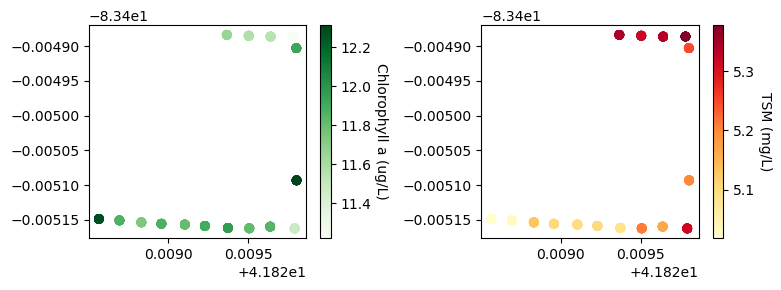

In [59]:
fig, ax = plt.subplots(1,2, figsize=(8,3), layout='tight')
for i in range(len(df)):  
    g1 = ax[0].scatter(df['Latitude'], df['Longitude'], c=df['chl_hu_ocx'], cmap='Greens')
    g2 = ax[1].scatter(df['Latitude'], df['Longitude'], c=df['tsm_nechad'], cmap='YlOrRd')

cbar = fig.colorbar(g1, ax=ax[0])
cbar.set_label('Chlorophyll a (ug/L)', rotation=270, labelpad=12)
cbar = fig.colorbar(g2, ax=ax[1])
cbar.set_label('TSM (mg/L)', rotation=270, labelpad=12)

plt.show()

Let's attempt to georeference the images based on the sensor yaw, pitch, roll, lat, lon, and altitude. Note that georeferencing can be inaccurate if the yaw, pitch, and roll information is imprecise. Let's look at the options in the `georeference()` function.

In [60]:
?georeference

Signature:
georeference(
    metadata,
    input_dir,
    output_dir,
    lines=None,
    altitude=None,
    yaw=None,
    pitch=0,
    roll=0,
    axis_to_flip=None,
)
Docstring:
This function georeferences all the captures indicated in the line parameter following the specification of the other parameters such as altitude, yaw, pitch, roll, axis_to_flip

Inputs:
metadata: A Pandas dataframe of the metadata
input_dir: A string containing the directory filepath of the images to be retrieved for georeferencing.
output_dir: A string containing the directory filepath to be saved. 
lines: Selection of images to be processed. Defaults to None. Example: [slice(0,10)]
altitude: sets the altitude where all captures were taken. Defaults to None which uses the altitude data saved in the metadata for each respective capture.
yaw: sets the sensor's direction angle during all captures. Defaults to None which uses the yaw angle saved in the metadata for each respective capture.
pitch: sets the senso

In [18]:
metadata = pd.read_csv(os.path.join(project_path, 'metadata.csv'))
input_dir = os.path.join(project_path, 'chl_hu_ocx_imgs') 
output_dir = os.path.join(project_path, 'georeferenced_chl_hu_ocx')

altitude = 87
yaw = 197
pitch = 0
roll = 0
axis_to_flip = [1]

lines = [ slice(0, 3) ]

georeference(metadata, input_dir, output_dir, lines, altitude, yaw, pitch, roll, axis_to_flip)

  0%|                                                     | 0/3 [00:00<?, ?it/s]


RasterioIOError: Broadford_Lake_UAS_imgs/chl_hu_ocx_imgs/capture_1.tif: No such file or directory

In [16]:
altitude = 87
yaw = 20
pitch = 0
roll = 0
axis_to_flip = [1]

lines = [ slice(8, 15) ]

georeference(metadata, input_dir, output_dir, lines, altitude, yaw, pitch, roll, axis_to_flip)

  0%|                                                     | 0/7 [00:00<?, ?it/s]


RasterioIOError: Broadford_Lake_UAS_imgs/chl_hu_ocx_imgs/capture_9.tif: No such file or directory

Let's plot a few of these georeferenced images

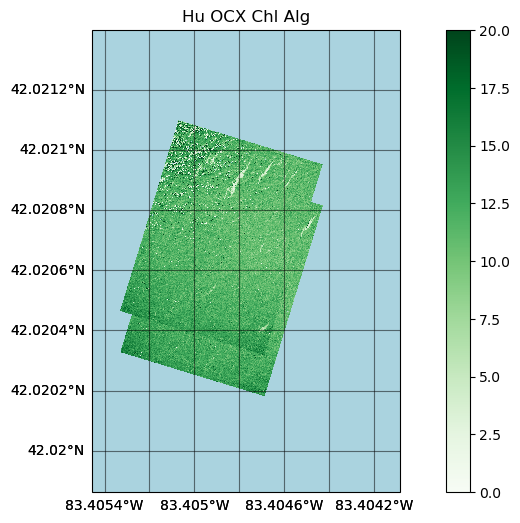

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))
ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename=r"sample_datasets/lake_dataset/georeferenced_chl_hu_ocx/capture_1.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename=r"sample_datasets/lake_dataset/georeferenced_chl_hu_ocx/capture_2.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)

ax_0.set_title(f'Hu OCX Chl Alg')
plt.colorbar(mappable_0)


We can mosaic all of the individual georeferenced images. Let's look at the options.

In [63]:
?mosaic

Signature:
mosaic(
    input_dir,
    output_dir,
    output_name,
    method='mean',
    dtype=<class 'numpy.float32'>,
    band_names=None,
)
Docstring:
This function moasics all the given rasters into a single raster file 

Inputs:
input_dir: a string containing the directory filepath of images to be mosaicked 
output_dir: a string containing the directory filepath to save the output
output_name: a string of the output name of mosaicked .tif
method: Method to be used when multiple captures coincide at same location. Options: 'mean', 'first', 'min', 'max'. Defaults to 'mean'.
dtype: dtype of the mosaicked raster. Defaults to np.float32.
band_names: List of band names. If it is not None, it writes one file for each band instead of one file with all the bands. Defaults to None.

Returns:
Mosaicked .tif file
File:      /home/jovyan/utils.py
Type:      function

In [15]:
input_dir = os.path.join(project_path, 'georeferenced_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

mosaic(input_dir, output_dir, output_name = 'mean_mosaic_chl_hu_ocx',
           method='mean', band_names = None) 

100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


'sample_datasets/lake_dataset/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif'

Now let's plot the mosaicked image

TODO: Figure out parameters to fix georeferencing

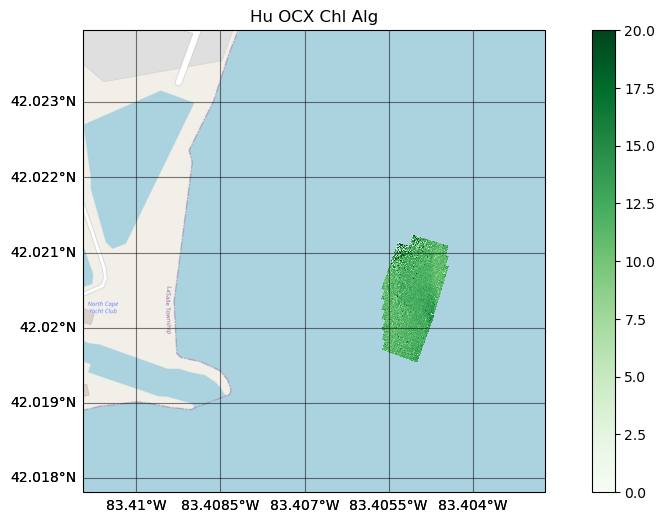

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))

west, north, east, south = -83.40981, 41.83149, -83.40374, 41.82788

plot_basemap(ax, west, south, east, north, cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename=r"sample_datasets/lake_dataset/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title(f'Hu OCX Chl Alg')
plt.colorbar(mappable_0)

We also have the option to downsample, that is reduce the spatial resolution, of the mosaic. This is helpful to reduce file size of the large mosaic. 

In [18]:
input_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')
output_dir = os.path.join(project_path, 'mosaic_chl_hu_ocx')

downsample(input_dir, output_dir, scale_x = 15, scale_y = 15, method = Resampling.average)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


And we can plot it

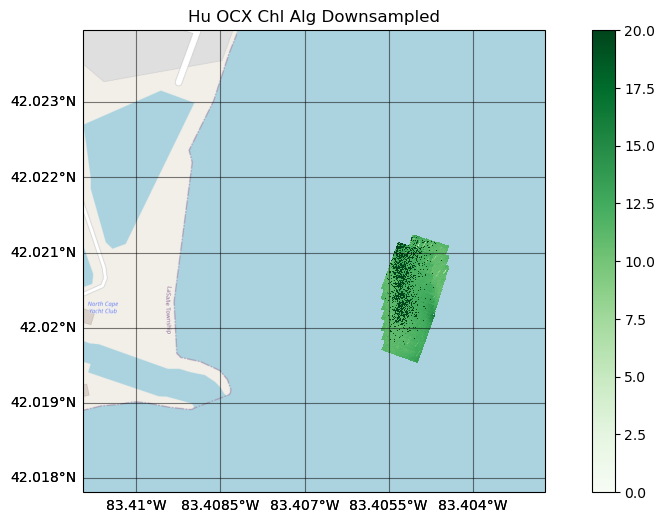

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(12, 6), subplot_kw = dict(projection = Mercator()))

west, north, east, south = -83.40981, 41.83149, -83.40374, 41.82788

plot_basemap(ax, west, south, east, north, cx.providers.OpenStreetMap.Mapnik)

ax_0, mappable_0 = plot_georeferenced_data(ax=ax, filename=r"sample_datasets/lake_dataset/mosaic_chl_hu_ocx/mean_mosaic_chl_hu_ocx__x_15__y_15__method_average.tif", 
                                           vmin=0, vmax=20, cmap='Greens', norm=None, basemap = cx.providers.OpenStreetMap.Mapnik)
ax_0.set_title(f'Hu OCX Chl Alg Downsampled')
plt.colorbar(mappable_0)